# Identification of Final Decisions and Outcomes for Case Files

## Introduction
This notebook aims to identify the final decisions and appeal decisions for each case file, as well as the corresponding outcomes. The project will address two types of final decisions based on the nature of the case closure: 
- **Judgments** (`sentencias`)
- **Orders** (`autos`)

For each type, we will adopt a different strategy to determine the nature of the final decision.

### Steps Overview
1. **Identification of Final Decisions:**
   - **Judgment (Sentencia):** We will identify cases concluded by a judgment.
   - **Order (Auto):** We will identify cases concluded by an order.
2. **Outcome Identification:**
   - We will first use a **regular expression (regex)** approach with relevant keywords to classify outcomes.
   - For cases where regex is not sufficient, a **trained large language model (LLM)** will support the text classification task.
3. **Judge Identification:**
   - Use a **pre-trained BERT model** to determine if the text in the column `'judge_from_opinion'` is a real person's name or another type of string.

### Detailed Steps

#### 1. Identifying Final Decisions
The identification process will differ based on the type of decision:
- **Judgment (`sentencia`)**: We will search for patterns that indicate a final decision was reached by judgment.
- **Order (`auto`)**: We will apply a similar approach to identify cases concluded by an order.

#### 2. Outcome Identification
Outcomes will be classified based on the decision text:
- **Regex Approach**: We will begin by searching for specific keywords or patterns that indicate the outcome.
- **Large Language Model (LLM)**: For cases where regex is insufficient, we will use a pre-trained LLM to support the text classification task and determine the outcome.

#### 3. Identifying Real Names in `judge_from_opinion`
We will employ a **BERT-based model** trained to recognize names of real people:
- The model will analyze the content of the `'judge_from_opinion'` column.
- The goal is to classify whether the text is a **real person's name** or **another type of string** (e.g., title, placeholder, or generic text).

### Tools and Technologies
- **Regular Expressions (Regex)** for pattern matching.
- **Large Language Model (LLM)** for natural language understanding and text classification.
- **BERT-based Model** for identifying personal names.

### Expected Output
- A labeled dataset where each case file has:
  - The final decision outcome.
  - A classification indicating whether `'judge_from_opinion'` is a real name.

In [1]:
import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import nltk
from datetime import datetime
import numpy as np

from transformers import AutoModelForSequenceClassification
from transformers import TextClassificationPipeline
from transformers import AutoTokenizer  # Or BertTokenizer

d:\Programas\anaconda3\envs\datasets_iat\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
year = '2018'

In [3]:
# Main functions 

def separate_case_files(main_df, second_df):

    ''' This code performs a left join between main_df and second_df based on the 'expediente_n°_' column, 
    and then returns a new DataFrame output_df that contains only the rows from main_df that do not have 
    a matching row in second_df based on the 'expediente_n°_' column.'''

    # Perform the merge and filter the results
    output_df = pd.merge(main_df, 
                         second_df[['case_file']], 
                         on='case_file', 
                         how='left', 
                         indicator=True).query('_merge == "left_only"').drop('_merge', axis=1)
    
    return output_df

# Function that creates a new dataset with only the cases that are associated with at least one 'acto_' containing 'vista'

def filter_vista_cases(df):

    ''' This code creates a new dataset with only the cases files that contains a higher court decision.'''
        
    # Create a boolean Series where True indicates that 'acto_' contains 'vista'
    contains_keyword = df['resolution_type'].str.contains('VISTA', na=False)

    # Group by 'expediente_n°_' and check if any 'acto_' in each group contains 'vista'
    grouped = df.groupby('case_file').apply(lambda x: any(x['resolution_type'].str.contains('VISTA', na=False)))

    # Create a new DataFrame containing only the 'expediente_n°_' that are associated with at least one 'acto_' containing 'vista'
    output_df = df[df['case_file'].isin(grouped[grouped].index)]
    
    return output_df


# Function that creates a new dataset with only the cases that are associated with at least one 'acto_' containing a specific keyword 

def filter_keywords_cases(df, keywords):

    ''' This code creates a new dataset with only the cases files that contains a specific keyword.'''
    
    # Use str.contains with the regex pattern
    pattern = '|'.join(keywords)

    contains_keyword = df['resolution_type'].str.contains(pattern, case = False ,na=False)
    
    # Group by 'expediente_n°_' and check if any 'acto_' in each group contains any of the keywords
    grouped = df.groupby('case_file').apply(lambda x: any(x['resolution_type'].str.contains(pattern, case = False , na=False)))
    
    # Create a new DataFrame containing only the 'expediente_n°_' that are associated with at least one 'acto_' containing keywords
    output_df = df[df['case_file'].isin(grouped[grouped].index)]
    
    return output_df


def contains_keywords(text, keywords):
    if text is None:
        return False
    text_lower = text.lower()
    return any(keyword.lower() in text_lower for keyword in keywords)


In [4]:
# This function calls a trained model that classifies if a text is a name or not. 
# This is useful to filter out the no names texts in the column 'judge_from_opinion', since we used a regex approach to extract the strings after the word 'Juez:'
# We will use this model after identifying which texts are final decisions, just to save CPU time.

tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
bert_model = AutoModelForSequenceClassification.from_pretrained("JFernandoGRE/classificator_names")
pipe_model = TextClassificationPipeline(model=bert_model, tokenizer=tokenizer)

def get_score(text):
    if pd.isna(text):
        return np.nan  
    return pipe_model(text, return_all_scores=True)[0][1]['score']

In [5]:
# Reading the dataset

documents_amag = pd.read_csv(rf'D:\Proyectos\amag\case_files_{year}.csv')

documents_amag['issued_date'] = pd.to_datetime(documents_amag['issued_date'])
documents_amag['start_date'] = pd.to_datetime(documents_amag['start_date'])

# Getting how many casefiles we have

documents_amag['judge_from_opinion'] = documents_amag['judge_from_opinion'].apply(lambda x: np.nan if isinstance(x, str) and len(x) > 40 else x)

expediente_counts = documents_amag['case_file'].value_counts()
total_unique_files = expediente_counts.shape[0]
print("Total case files:", total_unique_files)

Total case files: 141647


### 1) Separating Case Files
The first step in the analysis process is to separate the case files into two distinct categories:

1. Case Files Finished by Judgment
2. Case Files Not Finished by Judgment

**Case Files Finished by Judgment** 
- These are the case files that have reached a final decision or judgment. They represent cases that have been resolved and concluded, if they were not appealed. These files typically contain the final ruling or sentence, along with the supporting evidence and legal arguments that led to the decision.

- Identifying and separating these case files is crucial because they represent the completed cases, where the legal process has run its course, and a **definitive outcome** has been reached.

**Case Files Not Finished by Judgment**
- In contrast, this category encompasses case files that have not yet reached a final judgment or decision, but could be concluded by other means. Also, these files could also represent ongoing or unresolved cases that are still in progress within the judicial system.

- There could be various reasons why a case file falls into this category:

    - The case is still being investigated or processed.
    - The case was closed by an order.
    - The parties requested concluding the procedure

Separating these case files from those finished by judgment is essential because they require different handling and analysis.

By clearly distinguishing between these two categories, the analysis can proceed more efficiently, focusing on the appropriate set of case files based on the specific objectives and requirements of the project.

In [6]:
judgements_df = documents_amag[documents_amag['resolution_type'].str.contains('sentencia', case=False, na=False)]

# List of keywords to filter out
keywords = ['AUTO Q DECLARA CONSENTIDA LA SENTENCIA', 'AUTO QUE DECLARA CONSENTIDA SENTENCIA', 'PUESTA A DESPACHO PARA SENTENCIA',
            'AUTO QUE DECLARA CONSENTIDA LA SENTENCIA/AUTO DE VISTA', 'RESOLUCION DE TRAIGASE PARA SENTENCIAR',
            'APELACION DE SENTENCIA', 'AUTO QUE DECLARA CONSENTIDA LA SENTENCIA', 'AUTO DE INTEGRACION DE SENTENCIA',
            'EJECUCION DE SENTENCIA', 'AMPLIACION DE SENTENCIA']

# Check if the 'resolution_type' column contains any of the keywords
mask = judgements_df['resolution_type'].str.contains('|'.join(keywords), case=False)

no_judgments = judgements_df[mask]
# Drop the rows containing the keywords in the 'resolution_type' column
judgements_df = judgements_df[~mask]

In [44]:
orders_df = separate_case_files(documents_amag, judgements_df)

In [23]:
expediente_counts = judgements_df['case_file'].value_counts()
a = expediente_counts.shape[0]
print("Total case files finished by judgements:", a)

expediente_counts = orders_df['case_file'].value_counts()
b = expediente_counts.shape[0]
print("Total case files not finished by judgements:", b)

print("Total case files", a + b)

Total case files finished by judgements: 41242
Total case files not finished by judgements: 100405
Total case files 141647


### 2) Approach with judgements

**Goals**

- Measure how much time it took to solve the case.
- Identify the outcomes for each final decision. 
- Identify if the first instance decision was confirmed or reversed.

**Approach**

For the case files that have reached a final judgment, we can further separate them into two groups:

1. Case Files with Higher Court Decision
2. Case Files with No Higher Court Decision

**Case Files with Higher Court Decision**
- These case files represent cases that have gone through two or multiple levels of the judicial system, typically involving an appeal process. By analyzing these files, we can:

    - Compare the decisions made at different levels of the judicial hierarchy (e.g., first instance vs. higher court).
    - Identify cases where the initial decision was confirmed or reversed by the higher court.

- Studying these case files can provide valuable insights into the efficiency and consistency of the judicial system, as well as the factors that influence the outcome of appealed cases.

**Case Files with No Higher Court Decision**
- These case files represent cases that were resolved at the initial level, without any further appeals or higher court involvement. By analyzing these files, we can:

    - Measure the duration of the legal process from filing to the final decision at the first instance.

By separating the case files based on the presence of a higher court decision, we can gain valuable insights into different aspects of the judicial system, such as the duration of legal proceedings, the consistency of decisions across different levels, and the factors that influence the outcome of appealed cases.

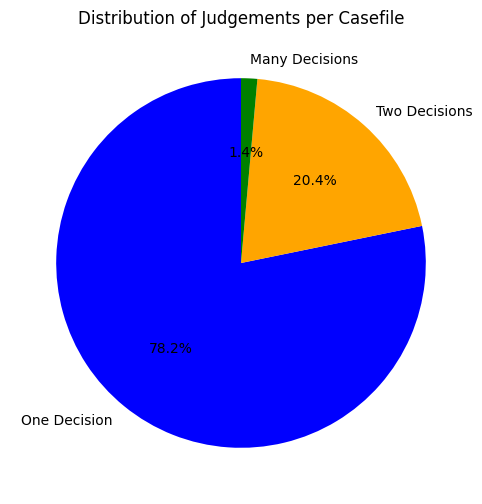

In [45]:
# Create three subsets based on the specified criteria
expediente_counts = judgements_df['case_file'].value_counts()

single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Judgements per Casefile')

plt.show()

In [64]:
# For appeal judgments
confirm_pattern = re.compile(r'c\s*o\s*n\s*f\s*i\s*r\s*m\s*a\s*r\s*', re.IGNORECASE)
consent_pattern = re.compile(r'c\s*o\s*n\s*s\s*e\s*n\s*t\s*i\s*r\s*', re.IGNORECASE)

# Reversal patterns for appeal judgments
revoc_pattern = re.compile(r'r\s*e\s*v\s*o\s*c\s*', re.IGNORECASE)
improcedente_pattern = re.compile(r'i\s*m\s*p\s*r\s*o\s*c\s*e\s*d\s*e\s*n\s*t\s*e\s*', re.IGNORECASE)
nulidad_pattern = re.compile(r'n\s*u\s*l\s*i\s*d\s*a\s*d\s*', re.IGNORECASE)
anula_pattern = re.compile(r'a\s*n\s*u\s*l\s*a\s*', re.IGNORECASE)


# For first-instance judgments
fundada_en_parte_pattern = re.compile(r'f\s*u\s*n\s*d\s*a\s*d\s*a\s*e\s*n\s*p\s*a\s*r\s*t\s*e\s*', re.IGNORECASE)
fundada_pattern = re.compile(r'f\s*u\s*n\s*d\s*a\s*d\s*a\s*', re.IGNORECASE)
infundada_pattern = re.compile(r'i\s*n\s*f\s*u\s*n\s*d\s*a\s*', re.IGNORECASE)


# Function to classify appeal judgments
def judgment_appeal(text): 
    if not isinstance(text, str):
        text = str(text) if text is not None else ''
    
    if revoc_pattern.search(text) or improcedente_pattern.search(text) or nulidad_pattern.search(text) or anula_pattern.search(text):
        return 'Reversal'
    
    elif confirm_pattern.search(text) or consent_pattern.search(text):
        return 'Confirmation'

    else:
        return 'Ambiguous'


# Function to classify first-instance judgments
def judgment_first(text): 
    if not isinstance(text, str):
        text = str(text) if text is not None else ''
    
    if fundada_en_parte_pattern.search(text):
        return 'Partial'
    
    elif infundada_pattern.search(text) or improcedente_pattern.search(text):
        return 'Defendant'
    
    elif fundada_pattern.search(text):
        return 'Plaintiff'

    else:
        return 'Ambiguous'


# Apply different logic based on the value of 'resolution_type'
def classify_judgment(row):
    # Ensure all values are strings, handling None/NaN values gracefully
    summary = str(row['summary']) if pd.notna(row['summary']) else ''
    resolution_type = str(row['resolution_type']) if pd.notna(row['resolution_type']) else ''
    verdict_text = str(row['verdict_text']) if pd.notna(row['verdict_text']) else ''
    
    # Check if 'vista' is in resolution_type
    if 'vista' in resolution_type.lower():  
        return judgment_appeal(summary + ' ' + resolution_type + ' ' + verdict_text)
    else:
        return judgment_first(summary + ' ' + resolution_type + ' ' + verdict_text)


# Apply the function to the DataFrame
judgements_df['outcome'] = judgements_df.apply(classify_judgment, axis=1)

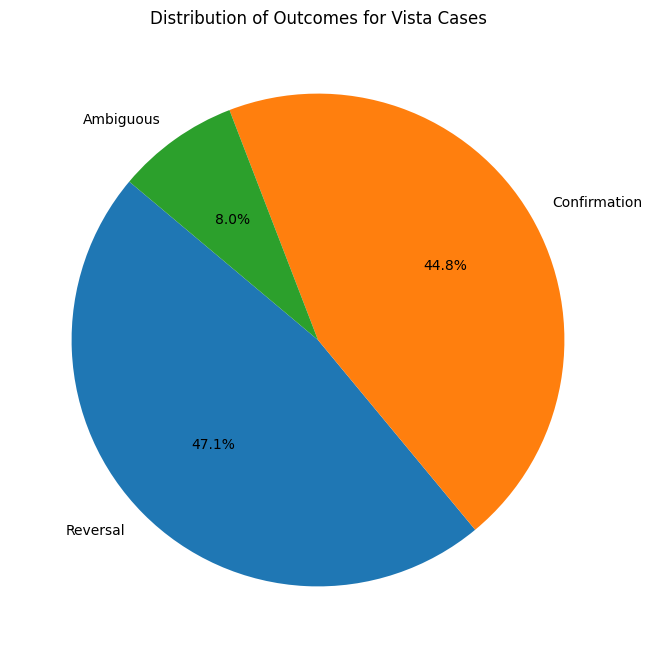

In [65]:
# Filter the rows where 'resolution_type' contains 'vista'
vista_df = judgements_df[judgements_df['resolution_type'].str.contains('VISTA', case=False, na=False)]

# Check if there are any rows with 'vista'
if not vista_df.empty:
    
    # Calculate the value counts of the 'outcome' column for the filtered rows
    outcome_counts = vista_df['outcome'].value_counts()
    
    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Outcomes for Vista Cases')
    plt.show()

else:
    print("No 'vista' found in the 'resolution_type' column.")


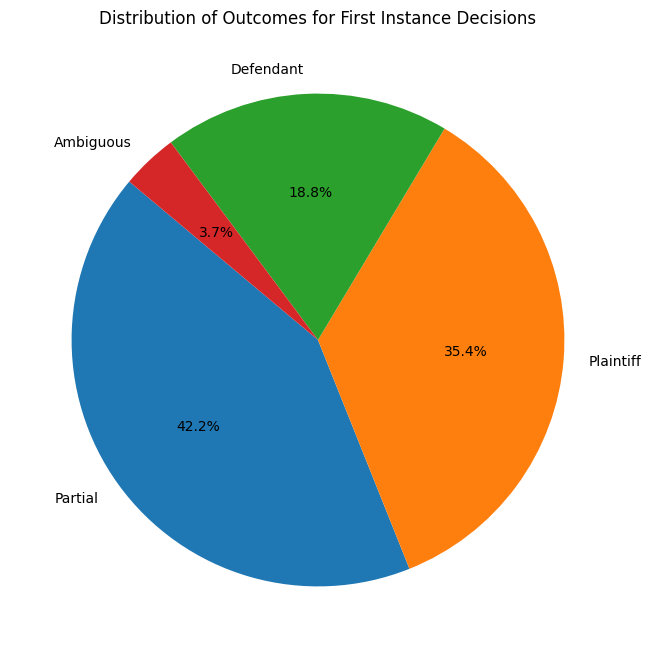

In [66]:
no_vista_df = judgements_df[~judgements_df['resolution_type'].str.contains('VISTA', case=False, na=False)]

# Check if there are any rows without 'vista'
if not no_vista_df.empty:
    
    # Calculate the value counts of the 'outcome' column for the filtered rows
    outcome_counts = no_vista_df['outcome'].value_counts()
    
    # Create a pie chart
    plt.figure(figsize=(8, 8))
    plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Outcomes for First Instance Decisions')
    plt.show()

else:
    print("All rows contain 'vista' in the 'resolution_type' column.")

In [52]:
judgements_2 = filter_vista_cases(judgements_df)
judgements_1 = separate_case_files(judgements_df, judgements_2)

In [53]:
judgements_2['second_instance'] = True
judgements_1['second_instance'] = False

C:\Users\PC\AppData\Local\Temp\ipykernel_17888\2351515552.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judgements_2['second_instance'] = True


In [54]:
# Case files with second_instance as True with only a single decision is weird, since it must has its first instance decision associated to it. 
# That's why we will remove it from our dataset

single_observation = expediente_counts[expediente_counts == 1].index

# Remove rows where 'case_file' is in single_observation
judgements_2 = judgements_2[~judgements_2['case_file'].isin(single_observation)]

In [55]:
# We need to have them into a single dataframe

judgements_case_file = pd.concat([judgements_1, judgements_2], ignore_index=True)

In [ ]:
# Fixing the names with BERT

# Apply the function to the 'JUDGE_FROM_OPINION' column and create the 'SCORE' column
judgements_case_file['score'] = judgements_case_file['judge_from_opinion'].apply(get_score)

judgements_case_file.loc[judgements_case_file['score'] < 0.998, 'judge_from_opinion'] = np.nan  # Set NaN where score > 0.998

# Copy content from 'judge' to 'judge_from_opinion' where 'judge_from_opinion' is empty
judgements_case_file['judge_from_opinion'].replace('', np.nan, inplace=True)  # Ensure empty strings are treated as NaN
judgements_case_file['judge_from_opinion'].fillna(judgements_case_file['judge'], inplace=True)

## 3) Approach with orders

We will assume that the case files above were solved. We will do the following:

1. Remove the closed case files from the judgments_df.
2. Keep only the rows that contains the word 'auto' in the column 'resolution_type'. As it was explained before, if there is no judgment, a procedure could be ended by an 'auto'.
3. We will create two datasets, the first one with lower and higher court decisions, and the other one with only the lower court decision. 

In [45]:
orders_df = orders_df[orders_df['resolution_type'].str.contains('auto', case=False, na=False)]

In [46]:
keywords = ['desistimiento', 'conciliación', 'conciliacion',
            'allanamiento', 'transacción', 'reconocimiento', 'abandono',
            'transaccion', 'final', 'improcedente', 'archivo definitivo', 
            'incompetencia', 'improcedencia',
            'sustraccion de la materia', 'conclusion', 'conclusión', 'vista']

orders_df = orders_df[orders_df['resolution_type'].str.contains('|'.join(keywords), case=False, na=False)]

In [47]:
expediente_counts = orders_df['case_file'].value_counts()
a = expediente_counts.shape[0]
print("", a)

 55073


In [48]:
# 1. Keywords for appeals

# Confirmation keywords for appeals
confirm_pattern = re.compile(r'c\s*o\s*n\s*f\s*i\s*r\s*m\s*a\s*r\s*', re.IGNORECASE)
consent_pattern = re.compile(r'c\s*o\s*n\s*s\s*e\s*n\s*t\s*i\s*r\s*', re.IGNORECASE)
improcedente_pattern = re.compile(r'i\s*m\s*p\s*r\s*o\s*c\s*e\s*d\s*e\s*n\s*t\s*e\s*', re.IGNORECASE)

# Reversal keywords for appeals
revoc_pattern = re.compile(r'r\s*e\s*v\s*o\s*c\s*', re.IGNORECASE)
nulidad_pattern = re.compile(r'n\s*u\s*l\s*i\s*d\s*a\s*d\s*', re.IGNORECASE)
anula_pattern = re.compile(r'a\s*n\s*u\s*l\s*a\s*', re.IGNORECASE)


# 2. Keywords for first instance decisions

# Plaintiff patterns 
fundada_en_parte_pattern = re.compile(r'f\s*u\s*n\s*d\s*a\s*d\s*a\s*e\s*n\s*p\s*a\s*r\s*t\s*e\s*', re.IGNORECASE)
fundada_pattern = re.compile(r'f\s*u\s*n\s*d\s*a\s*d\s*a\s*', re.IGNORECASE)
infundada_pattern = re.compile(r'i\s*n\s*f\s*u\s*n\s*d\s*a\s*', re.IGNORECASE)
improcedente_pattern = re.compile(r'i\s*m\s*p\s*r\s*o\s*c\s*e\s*d\s*e\s*n\s*t\s*e\s*', re.IGNORECASE)

# Settlement patterns
conciliacion_pattern = re.compile(r'c\s*o\s*n\s*c\s*i\s*l\s*i\s*a\s*', re.IGNORECASE)
transaccion_pattern = re.compile(r't\s*r\s*a\s*n\s*s\s*a\s*c\s*c\s*i\s*o\s*n\s*', re.IGNORECASE)

# Dropped by plaintiff patterns
abandono_pattern = re.compile(r'a\s*b\s*a\s*n\s*d\s*o\s*n\s*o\s*', re.IGNORECASE)
desistimiento_pattern = re.compile(r'd\s*e\s*s\s*i\s*s\s*t\s*i\s*m\s*i\s*e\s*n\s*t\s*o\s*', re.IGNORECASE)
inasist_pattern = re.compile(r'i\s*n\s*a\s*s\s*i\s*s\s*t\s*', re.IGNORECASE)

# Defendant patterns
infundada_pattern = re.compile(r'i\s*n\s*f\s*u\s*n\s*d\s*a\s*', re.IGNORECASE)
improcedente_pattern = re.compile(r'i\s*m\s*p\s*r\s*o\s*c\s*e\s*d\s*e\s*n\s*t\s*e\s*', re.IGNORECASE)
rechazar_pattern = re.compile(r'r\s*e\s*c\s*h\s*a\s*z\s*a\s*r\s*', re.IGNORECASE)
nulidad_pattern = re.compile(r'n\s*u\s*l\s*i\s*d\s*a\s*d\s*', re.IGNORECASE)    
incompentencia_pattern = re.compile(r'i\s*n\s*c\s*o\s*m\s*p\s*e\s*t\s*e\s*n\s*c\s*i\s*a\s*', re.IGNORECASE)
sin_declaración_pattern = re.compile(r's\s*i\s*n\s*d\s*e\s*c\s*l\s*a\s*r\s*a\s*c\s*i\s*ó\s*n\s*', re.IGNORECASE)

# Partial patterns
fundada_en_parte_pattern = re.compile(r'f\s*u\s*n\s*d\s*a\s*d\s*a\s*e\s*n\s*p\s*a\s*r\s*t\s*e\s*', re.IGNORECASE)

# Plaintiff patterns
fundada_pattern = re.compile(r'f\s*u\s*n\s*d\s*a\s*d\s*a\s*', re.IGNORECASE)
llevar_adelante_pattern = re.compile(r'l\s*l\s*e\s*v\s*a\s*r\s*\s*a\s*d\s*e\s*l\s*a\s*n\s*t\s*e\s*', re.IGNORECASE)
allana_pattern = re.compile(r'a\s*l\s*l\s*a\s*n\s*a\s*', re.IGNORECASE)
adelante_pattern = re.compile(r'a\s*d\s*e\s*l\s*a\s*n\s*t\s*e\s*', re.IGNORECASE)



# Function to classify appeal judgments
def order_appeal(text): 
    if not isinstance(text, str):
        text = str(text) if text is not None else ''
    
    if revoc_pattern.search(text) or nulidad_pattern.search(text) or anula_pattern.search(text):
        return 'Reversal'
    
    elif confirm_pattern.search(text) or consent_pattern.search(text) or improcedente_pattern.search(text):
        return 'Confirmation'

    else:
        return 'Ambiguous'


# Function to classify first-instance judgments
def order_first(text): 
    if not isinstance(text, str):
        text = str(text) if text is not None else ''
    
    if conciliacion_pattern.search(text) or transaccion_pattern.search(text):
        return 'Settlement'
    
    elif abandono_pattern.search(text) or desistimiento_pattern.search(text) or inasist_pattern.search(text):
        return 'Dropped by Plaintiff'
    
    elif fundada_en_parte_pattern.search(text):
        return 'Partial'
    
    elif infundada_pattern.search(text) or improcedente_pattern.search(text) or rechazar_pattern.search(text) or nulidad_pattern.search(text) or incompentencia_pattern.search(text) or sin_declaración_pattern.search(text):
        return 'Defendant'
    
    elif fundada_pattern.search(text) or llevar_adelante_pattern.search(text) or allana_pattern.search(text) or adelante_pattern.search(text):
        return 'Plaintiff'

    else:
        return 'Ambiguous'


# Apply different logic based on the value of 'resolution_type'
def classify_order(row):
    # Ensure all values are strings, handling None/NaN values gracefully
    summary = str(row['summary']) if pd.notna(row['summary']) else ''
    resolution_type = str(row['resolution_type']) if pd.notna(row['resolution_type']) else ''
    verdict_text = str(row['verdict_text']) if pd.notna(row['verdict_text']) else ''
    
    # Check if 'vista' is in resolution_type
    if 'vista' in resolution_type.lower():  
        return order_appeal(summary + ' ' + resolution_type + ' ' + verdict_text)
    else:
        return order_first(summary + ' ' + resolution_type + ' ' + verdict_text)


# Apply the function to the DataFrame
orders_df['outcome'] = orders_df.apply(classify_order, axis=1)

In [49]:
orders_2 = filter_vista_cases(orders_df)
orders_1 = separate_case_files(orders_df, orders_2)
orders_2['second_instance'] = True
orders_1['second_instance'] = False 

C:\Users\PC\AppData\Local\Temp\ipykernel_5808\3942085564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_2['second_instance'] = True


In [55]:
orders_case_file = pd.concat([orders_1, orders_2], ignore_index=True)

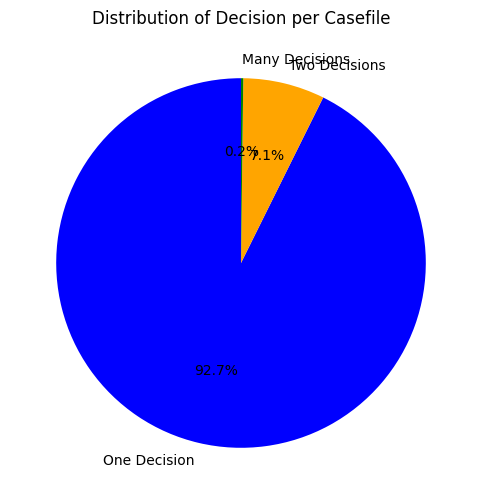

In [56]:
expediente_counts = orders_1['case_file'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[(expediente_counts >= 3) & (expediente_counts <= 10)]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Decision per Casefile')

plt.show()

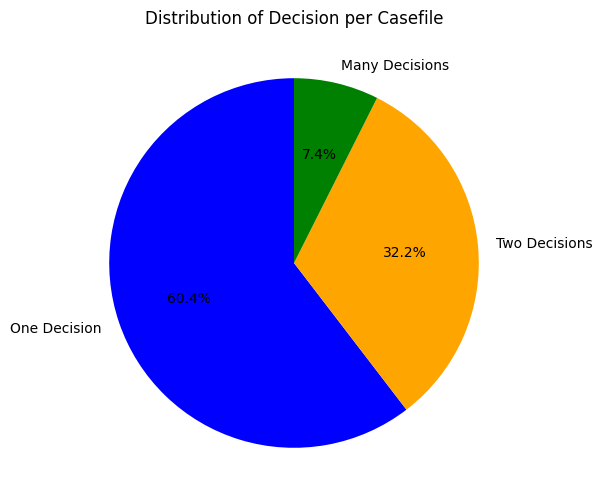

In [66]:
expediente_counts = orders_2['case_file'].value_counts()

# Create three subsets based on the specified criteria
single_observation = expediente_counts[expediente_counts == 1]
second_observations = expediente_counts[expediente_counts == 2]
third_observations = expediente_counts[expediente_counts >= 3]

total_count = len(expediente_counts)
single_percentage = len(single_observation) / total_count * 100
second_percentage = len(second_observations) / total_count * 100
third_percentage = len(third_observations) / total_count * 100

# Plotting
plt.figure(figsize=(10, 6))

labels = ['One Decision', 'Two Decisions', 'Many Decisions']
sizes = [single_percentage, second_percentage, third_percentage]
colors = ['blue', 'orange', 'green']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Decision per Casefile')

plt.show()

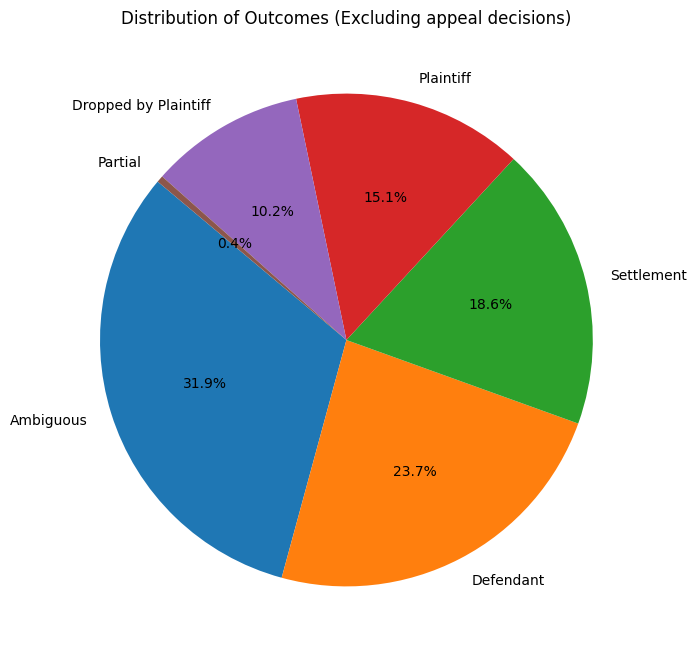

In [63]:
# Filter out rows where 'resolution_type' contains the word 'vista' (case-insensitive)
filtered_orders = orders_case_file[~orders_case_file['resolution_type'].str.contains('vista', case=False, na=False)]

# Calculate the value counts for 'outcome' based on the filtered DataFrame
outcome_counts = filtered_orders['outcome'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Outcomes (Excluding appeal decisions)')
plt.show()

In [ ]:
# Since there are many outcomes classified as ambiguous, we will use a trained model to classify them.



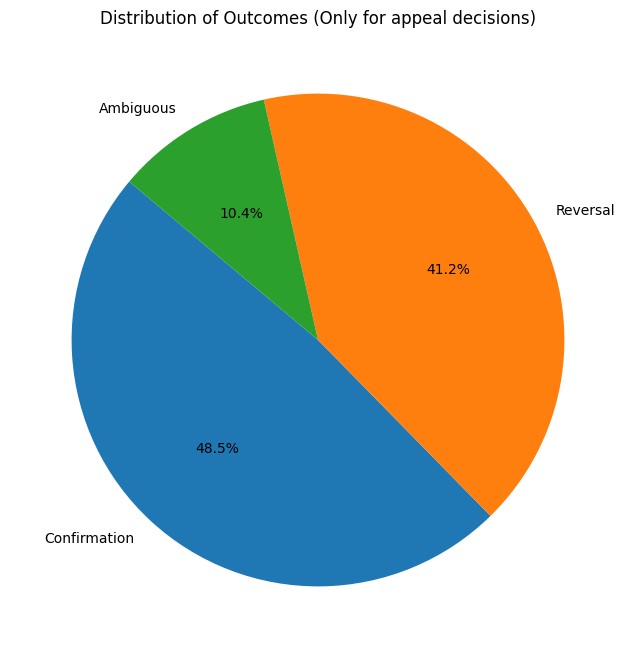

In [64]:
# Filter out rows where 'resolution_type' contains the word 'vista' (case-insensitive)
filtered_orders = orders_case_file[orders_case_file['resolution_type'].str.contains('vista', case=False, na=False)]

# Calculate the value counts for 'outcome' based on the filtered DataFrame
outcome_counts = filtered_orders['outcome'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Outcomes (Only for appeal decisions)')
plt.show()

In [ ]:
# Fixing the names with BERT

# Apply the function to the 'JUDGE_FROM_OPINION' column and create the 'SCORE' column
orders_case_file['score'] = orders_case_file['judge_from_opinion'].apply(get_score)

orders_case_file.loc[orders_case_file['score'] < 0.998, 'judge_from_opinion'] = np.nan  # Set NaN where score > 0.998

# Copy content from 'judge' to 'judge_from_opinion' where 'judge_from_opinion' is empty
orders_case_file['judge_from_opinion'].replace('', np.nan, inplace=True)  # Ensure empty strings are treated as NaN
orders_case_file['judge_from_opinion'].fillna(orders_case_file['judge'], inplace=True)

In [ ]:
final_decisions = pd.concat([judgements_case_file, orders_case_file], ignore_index=True)
final_decisions.to_csv(rf'final_decisions_{year}.csv', index=False)